In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load datasets
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(ConvModule, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x)

class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1, ch3):
        super(InceptionModule, self).__init__()
        # 1x1 branch
        self.branch1x1 = ConvModule(in_channels, ch1, kernel_size=1)

        # 3x3 branch
        self.branch3x3 = ConvModule(in_channels, ch3, kernel_size=3, padding=1)

    def forward(self, x):
        out1x1 = self.branch1x1(x)
        out3x3 = self.branch3x3(x)
        # Concatenate along the channel dimension
        return torch.cat([out1x1, out3x3], dim=1)

class DownsampleModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownsampleModule, self).__init__()
        # 3x3 conv branch with stride 2
        self.conv = ConvModule(in_channels, out_channels, kernel_size=3, stride=2, padding=1)

        # Max pooling branch
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        out_conv = self.conv(x)
        out_pool = self.pool(x)
        # Concatenate along the channel dimension
        return torch.cat([out_conv, out_pool], dim=1)

class SmallInception(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallInception, self).__init__()

        # Initial conv layer: Adjusted input channels to 1 for FashionMNIST (grayscale input)
        self.conv1 = ConvModule(1, 96, kernel_size=3, stride=1, padding=1)

        # First Inception Block
        self.inception1 = InceptionModule(96, ch1=32, ch3=32)  # Output: 32+32=64 channels
        self.inception2 = InceptionModule(64, ch1=32, ch3=48)  # Output: 32+48=80 channels

        # Downsampling
        self.downsample1 = DownsampleModule(80, 80)

        # Second Inception Block
        self.inception3 = InceptionModule(160, ch1=112, ch3=48)  # Output: 112+48=160 channels
        self.inception4 = InceptionModule(160, ch1=96, ch3=64)   # Output: 96+64=160 channels
        self.inception5 = InceptionModule(160, ch1=80, ch3=80)   # Output: 80+80=160 channels
        self.inception6 = InceptionModule(160, ch1=48, ch3=96)   # Output: 48+96=144 channels

        # Downsampling
        self.downsample2 = DownsampleModule(144, 48)

        # Final Inception Block
        self.inception7 = InceptionModule(192, ch1=176, ch3=160)  # Output: 176+160=336 channels
        self.inception8 = InceptionModule(336, ch1=176, ch3=160)  # Output: 176+160=336 channels

        # Global average pooling
        self.global_pool = nn.AvgPool2d(kernel_size=7)

        # Fully connected layer for classification
        self.fc = nn.Linear(336, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.downsample1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.downsample2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)






100%|██████████| 26421880/26421880 [00:03<00:00, 8127441.02it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 139065.84it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 691864.20it/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6165698.74it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
# Assuming you have the SmallInception model and train_loader defined
model = SmallInception()
criterion = nn.CrossEntropyLoss()

# Change optimizer to SGD with momentum (optional)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # You can adjust the lr and momentum

lrs = []
losses = []

# Testing different learning rates
for lr in torch.logspace(-9, 1, 10):
    optimizer.param_groups[0]['lr'] = lr
    running_loss = 0.0
    print("Running for lr ", lr)
    for epoch in range(5):
        print("Running epoch ", epoch)
        for i, (images, labels) in enumerate(train_loader):

            if i > 10:  # Limiting to 10 batches per epoch for speedup
                break
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


    lrs.append(lr)
    losses.append(running_loss / len(train_loader))

    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Loss vs Learning Rate')
    plt.show()

# Plot the results
plt.plot(lrs, losses)
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Loss vs Learning Rate')
plt.show()


In [3]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CyclicLR
import matplotlib.pyplot as plt

# Assuming model is already defined and instantiated
model = SmallInception()  # Using the SmallInception model

# Criterion (Loss Function) and Optimizer
criterion = torch.nn.CrossEntropyLoss()

# Initializing the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Learning rate range obtained from part 1
lrmin = 1e-2  # You should replace this with the lrmin found in part 1
lrmax = 1  # You should replace this with the lrmax found in part 1

# Cyclical Learning Rate Scheduler
scheduler = CyclicLR(optimizer, base_lr=lrmin, max_lr=lrmax, step_size_up=2000, mode='exp_range', gamma=0.99)

# Containers to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training Loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss, correct = 0.0, 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        if i > 10:  # Limiting to 10 batches per epoch for speedup
            break

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Update weights
        optimizer.step()
        scheduler.step()  # Update the learning rate per batch

        # Track training loss and accuracy
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation Phase
    model.eval()
    val_loss, correct = 0.0, 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / len(test_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print metrics
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    # Decay the lrmin and lrmax values exponentially after each epoch
    lrmin *= 0.99  # Adjust decay factor as needed
    lrmax *= 0.99
    scheduler.base_lrs = [lrmin]  # Update the scheduler's learning rate range



Epoch 1/30, Train Loss: 0.0242, Train Accuracy: 0.2898, Val Loss: 2.3322, Val Accuracy: 0.1000
Epoch 2/30, Train Loss: 0.0149, Train Accuracy: 0.6122, Val Loss: 2.3466, Val Accuracy: 0.1351
Epoch 3/30, Train Loss: 0.0102, Train Accuracy: 0.7045, Val Loss: 2.5851, Val Accuracy: 0.1842
Epoch 4/30, Train Loss: 0.0087, Train Accuracy: 0.7230, Val Loss: 0.9970, Val Accuracy: 0.6271
Epoch 5/30, Train Loss: 0.0086, Train Accuracy: 0.7244, Val Loss: 1.7582, Val Accuracy: 0.4998
Epoch 6/30, Train Loss: 0.0076, Train Accuracy: 0.7585, Val Loss: 1.0576, Val Accuracy: 0.6692
Epoch 7/30, Train Loss: 0.0071, Train Accuracy: 0.7713, Val Loss: 0.8580, Val Accuracy: 0.7211
Epoch 8/30, Train Loss: 0.0075, Train Accuracy: 0.7656, Val Loss: 0.7492, Val Accuracy: 0.7460
Epoch 9/30, Train Loss: 0.0068, Train Accuracy: 0.7884, Val Loss: 1.7143, Val Accuracy: 0.5281
Epoch 10/30, Train Loss: 0.0070, Train Accuracy: 0.7741, Val Loss: 0.6765, Val Accuracy: 0.7542
Epoch 11/30, Train Loss: 0.0059, Train Accuracy: 

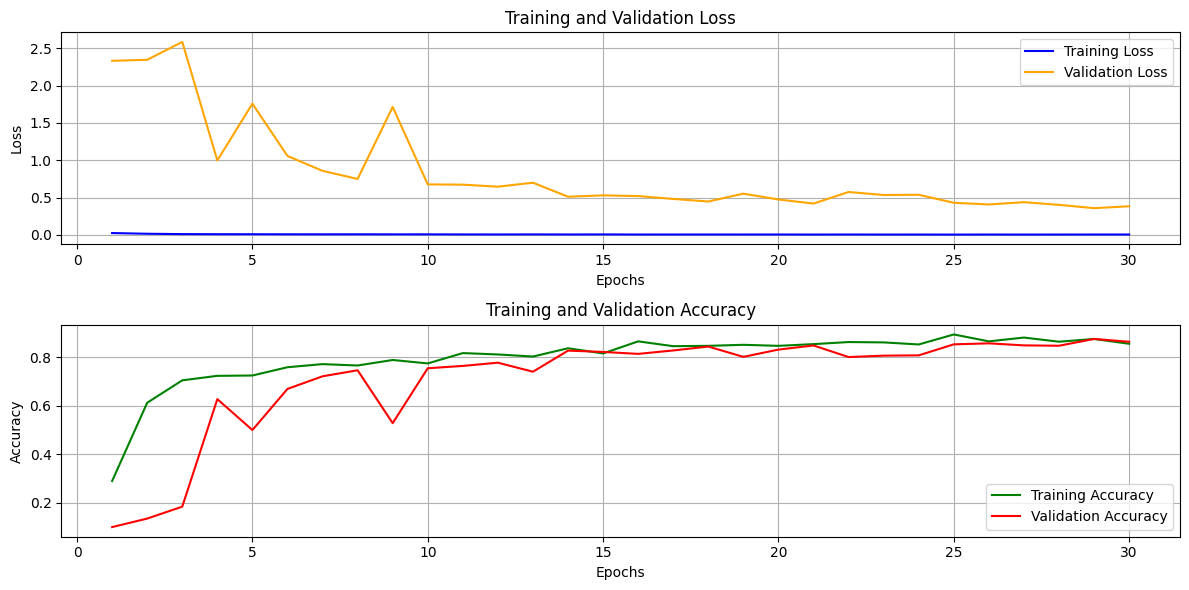

In [4]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(12, 6))

# Subplot for Loss
plt.subplot(2, 1, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Subplot for Accuracy
plt.subplot(2, 1, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='green')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
# Define transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load datasets
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Learning Rate (Set this to lrmax found in part 1)
lrmax = 1  # Replace with your lrmax value

# Batch sizes to test
batch_sizes = [32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]

# Store losses for each batch size
batch_loss = {}

# Training Loop for each batch size
for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")

    # Create DataLoader with the current batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define model, criterion and optimizer
    model = SmallInception()  # Using the SmallInception model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lrmax, momentum=0.9)

    # Store training loss
    running_loss = []
    num_epochs = 5  # You can adjust this based on your requirement

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Average loss for the epoch
        running_loss.append(epoch_loss / len(train_loader))
        print(f'Epoch {epoch+1}, Loss: {running_loss[-1]:.4f}')

    # Store the final loss for the current batch size
    batch_loss[batch_size] = running_loss[-1]

# Plotting the training loss for each batch size
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, list(batch_loss.values()), marker='o')
plt.xscale('log')
plt.title('Training Loss vs Batch Size')
plt.xlabel('Batch Size (log scale)')
plt.ylabel('Training Loss')
plt.xticks(batch_sizes, batch_sizes)  # Show actual batch sizes on x-axis
plt.grid()
plt.show()

Training with batch size: 32
